Assignment 3: Image Classification using CNNs
===

In this assignment you will learn about
1. The fundamental computations in neural networks for vision, including backpropagation
2. The basics of fitting a model for generalization
3. Nearest neighbor classifiers

**Note:** When you first load this colab webpage, it will be in read-only viewing mode.  To edit and run code, you can either (a) download the Jupyter notebook ("File" -> "Download .ipynb") to run on your local computer or (b) copy to your Google Drive ("File" -> "Save a copy in Drive...") to work in the browser and run on a Google Cloud GPU.  If you run locally, you will need to install Tensorflow and it is recommended that you use a GPU for problem 3.2.  If you do not want to use Colab and do not have a local GPU, please let us know.


# 3.0 Nearest neighbor classification (20 points)

## 3.0.1 (20 points) 
Given the following training set of labeled two-dimensional points for binary classification, draw a Voronoi diagram of the output of a 1-nearest neighbor classifier.  Feel free to render the diagram using Python below (do not use scikit-learn or any machine learning libraries to do this) or submit a PDF along with your assignment.

>```
Point (x,y)  | Label
-------------|-------
(1,3)        |   +
(-4,-2)      |   +
(-3,-1.5)    |   -
(3,3)        |   -
(0,-2)       |   +
(-2,0)       |   +
(-2,4)       |   -
```



In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from math import sqrt

points = np.array([
    [1,3,1],
    [-4,-2,1],
    [-3,-1.5,-1],
    [3,3,-1],
    [0,-2,1],
    [-2, 0, 1],
    [-2,4, -1]
])

class VoronoiGenerator(object):
    def __init__(self, points, step=0.1):
        self.points = points
        self.step = step
    def plot_voronoi(self, neighbours=1):
        print(self.points.shape)
        x_pos = []
        y_pos = []
        x_neg = []
        y_neg = []

        for x in np.arange(-50., 50., self.step):
            for y in np.arange(-50.,50.,self.step):
                dists = []
                min_labels = []
                label = None
                for point in points:
                    dist =sqrt( (point[0] - x)**2 + (point[1] - y)**2 )
                    dists.append((point[0], point[1], dist, point[2]))
                dists.sort(key=lambda x: x[2])
                for i in range(neighbours):
                    min_labels.append(dists[i][3])
                if np.sum(min_labels) >= 0:
                    x_pos.append(x)
                    y_pos.append(y)
                else:
                    x_neg.append(x)
                    y_neg.append(y)

        plt.plot(x_pos, y_pos, 'ro')
        plt.plot(x_neg, y_neg, 'bo')
        plt.plot(points[:, 0], points[:, 1], 'go')
        plt.axis([-5, 5, -5, 5])
        plt.show()


voronoi = VoronoiGenerator(points, step=.01)
voronoi.plot_voronoi(neighbours=1)

(7, 3)


KeyboardInterrupt: 

## 3.0.2 (5 points, extra) 

Render for 3-NN

In [ ]:
voronoi.plot_voronoi(neighbours=3)

# 3.1 Neural network operations (40 points)

In this section we provide a working example of a convolutional neural network written using basic numpy operations.  Each neural network operation is represented by a Python class with methods *forward()* and *backward()*, which compute activations and gradients, respectively. Your task is to complete certain methods that are left blank.

1. 2D Convolution
> * Forward
> * **Backward (10 points)**
2. ReLU
> * **Forward (5 points)**
> * Backward
3. Average pooling
> * Forward
> * **Backward (5 points)**
4. Softmax cross-entropy
> * **Forward (10 points)**
> * Backward

When you complete an operation, you can check your work by executing its cell.  We compare the outputs of your method to that of Tensorflow.

Finally, when you have all of the operations completed, you can run a small network for a few iterations of stochastic gradient descent and plot the loss.


In [24]:
#@title (Hidden utility code: RUN ME FIRST) { display-mode: "form" }
import tensorflow as tf
import numpy as np

class Variable:
  """Placeholder for labels and input images"""
  value = 0

def cmp_ops(your_op, tf_op, tf_inputs, tf_weights=None):
  your_op.forward()
  your_op_f_out = your_op.value

  with tf.Session().as_default():
    tf_op_f_out = tf_op.eval()[0] # Remove the batch dimension

  print("Forward pass:")
  cmp_tensors(your_op_f_out, tf_op_f_out, verbose=False)

  your_op.inputs.dloss_dvalue = np.zeros(your_op.inputs.value.shape)
  your_op.dloss_dvalue = np.ones(your_op.value.shape)
  your_op.backward()
  your_op_g_inputs = your_op.inputs.dloss_dvalue

  if tf_weights is not None:
    your_op_g_weights = your_op.dloss_dweights
    g_inputs, g_weights = tf.gradients(tf.reduce_sum(tf_op), [tf_inputs, tf_weights])
    
    with tf.Session() as sess:
      tf_g_inputs_out, tf_g_weights_out = sess.run([g_inputs, g_weights])
      tf_g_weights_out = np.transpose(tf_g_weights_out, [3,0,1,2])
    
    print("Gradient wrt inputs:")
    cmp_tensors(your_op_g_inputs, tf_g_inputs_out[0])
    print("Gradient wrt weights:")
    cmp_tensors(your_op_g_weights, tf_g_weights_out)
    
  else:
    g_inputs = tf.gradients(tf.reduce_sum(tf_op), [tf_inputs])

    with tf.Session() as sess:
      tf_g_inputs_out = sess.run(g_inputs)

    print("Gradient wrt inputs:")
    cmp_tensors(your_op_g_inputs, tf_g_inputs_out[0], verbose=False)

def cmp_tensors(yours, tfs, verbose=False):
  print("  Your Op shape: " + str(yours.shape))
  print("  TensorFlow Op shape: " + str(tfs.shape))
  print("  Values equal: " + str(np.allclose(tfs, yours, atol=1e-6)))
  if verbose:
    print(tfs)
    print(yours)
    
inputs = Variable()
inputs.value = np.random.normal(size=(10, 10, 3)) # Input image is 10x10x3
tf_inputs = tf.constant(inputs.value[np.newaxis, ...], dtype=tf.float32)

## 3.1.1 2D Convolution (10 pts)

In [25]:
import numpy as np

"""rows x cols x filters"""

class OpConv2D:
  """Two-dimensional convolutional layer"""
    
  def __init__(self, filters, kernel_size, inputs):
    # Shape of the input feature map
    input_height = inputs.value.shape[0]
    input_width = inputs.value.shape[1]
    input_filters = inputs.value.shape[2]
    
    # Shape of this layer's feature map
    self.height = input_height - kernel_size + 1
    self.width = input_width - kernel_size + 1
    self.filters = filters #Activations
    
    self.inputs = inputs
    self.kernel_size = kernel_size
    self.weights = np.random.normal(size=(filters, kernel_size, kernel_size, input_filters), scale=0.1)
    self.reset_values()
    
  def reset_values(self):
    self.value = np.zeros((self.height, self.width, self.filters))
    self.dloss_dvalue = np.zeros(self.value.shape) # Output1
    self.dloss_dweights = np.zeros(self.weights.shape) # Output2
    
  def forward(self):
    # Reset value and gradient at start of forward pass
    self.reset_values()
    
    for y in range(self.height):
      for x in range(self.width):
        for f in range(self.filters):
          z = 0.0
          
          for ky in range(self.kernel_size):
            for kx in range(self.kernel_size):
              for kf in range(self.weights.shape[3]):
                z += self.inputs.value[y+ky, x+kx, kf] * self.weights[f, ky, kx, kf]
                
          self.value[y, x, f] = z
#     print(self.value.shape)
          
  def backward(self):
    ## Complete this method, which sets:
    ## 1. Partial derivative of the loss with respect to the values of the inputs
    ## self.inputs.dloss_dvalue, which is a `height x width x input_filters` tensor
    ## 2. Partial derivative of the loss with respect to the weights
    ## self.dloss_dweights, which is a `filters x kernel_size x kernel_size x input_filters` tensor
    ##
    ## This will utilize tensors:
    ## 1. The partial with respect to the value of this layer
    ## self.dloss_dvalue, a `height x width x filter` tensor
    ## 2. The weights of this layer
    ## self.weights, a `filters x kernel_size x kernel_size x input_filters` tensor
    ## 3. The value of the input layer
    ## self.inputs.value, a `height x width x input_filters` tensor
    
#     print('dloss_dvalue=')
#     print(self.dloss_dvalue.shape) # Partial derivative of the loss w.r.t.  outputs
#     print('Weights=') # values of the weights
#     print(self.weights.shape)
#     print('Input Values=')
#     print(self.inputs.value.shape) # value of input values
#     print('Output Values=')
#     print(self.value.shape) # value of input values
    
    for h in range(self.height): #8
        for w in range(self.width): #8
            for f in range(self.filters): #4
                self.dloss_dweights[f] += self.inputs.value[h:h+self.kernel_size,w:w+self.kernel_size,:] * self.dloss_dvalue[h,w,f]
                self.inputs.dloss_dvalue[h:h+self.kernel_size, w:w+self.kernel_size, :] +=  self.weights[f,:,:,:] * self.dloss_dvalue[h,w,f]          
                
  def gradient_step(self, step_size):
    self.weights -= step_size * self.dloss_dweights
    
# Double check that op matches tensorflow
print("Testing Conv2D...")
op1 = OpConv2D(filters=4, kernel_size=3, inputs=inputs)

tf_weights = tf.constant(np.transpose(op1.weights, [1,2,3,0]), dtype=tf.float32)
tf_op1 = tf.nn.conv2d(tf_inputs,
                      tf_weights,
                      [1,1,1,1],
                      'VALID')
cmp_ops(op1, tf_op1, tf_inputs, tf_weights)

Testing Conv2D...
Forward pass:
  Your Op shape: (8, 8, 4)
  TensorFlow Op shape: (8, 8, 4)
  Values equal: True
Gradient wrt inputs:
  Your Op shape: (10, 10, 3)
  TensorFlow Op shape: (10, 10, 3)
  Values equal: True
Gradient wrt weights:
  Your Op shape: (4, 3, 3, 3)
  TensorFlow Op shape: (4, 3, 3, 3)
  Values equal: True


## 3.1.2 ReLU (5 pts)

In [26]:
class OpRelu:
  """Elementwise relu operator"""
    
  def __init__(self, inputs):
    # Shape of the input feature map
    self.input_shape = inputs.value.shape # 10x10x3
    self.inputs = inputs # Class variable with Value
    self.reset_values()
    
  def reset_values(self):
    self.value = np.zeros(self.inputs.value.shape)  # 10x10x3
    self.dloss_dvalue = np.zeros(self.inputs.value.shape)
    
  def forward(self):
    # Reset value and gradient at start of forward pass
    self.reset_values()
    ## Complete this code by setting self.value using self.inputs.value
    self.value = np.maximum(self.inputs.value,0.0)
          
  def backward(self):
    self.inputs.dloss_dvalue = self.dloss_dvalue * np.greater(self.value, 0.0)
                
  def gradient_step(self, step_size):
    pass    
  
# Double check that each op matches tensorflow
print("\nTesting Relu...")
print(inputs.value.shape)
op2 = OpRelu(inputs)
tf_op2 = tf.nn.relu(tf_inputs)
cmp_ops(op2, tf_op2, tf_inputs)


Testing Relu...
(10, 10, 3)
Forward pass:
  Your Op shape: (10, 10, 3)
  TensorFlow Op shape: (10, 10, 3)
  Values equal: True
Gradient wrt inputs:
  Your Op shape: (10, 10, 3)
  TensorFlow Op shape: (1, 10, 10, 3)
  Values equal: True


## 3.1.3 Average Pooling (5 pts)

In [27]:
class OpAvgPool:
  """Average pooling layer. Non-overlapping cells."""
    
  def __init__(self, cell_size, inputs):
    # Shape of the input feature map
    self.input_height = inputs.value.shape[0] #10
    self.input_width = inputs.value.shape[1] #10
    self.input_filters = inputs.value.shape[2] #3
    
    # Shape of this layer's feature map
    self.height = (self.input_height + cell_size - 1) // cell_size #5
    self.width = (self.input_width + cell_size - 1) // cell_size #5
    self.filters = self.input_filters #3
    
    self.inputs = inputs
    self.cell_size = cell_size #2
    self.reset_values()
    
  def reset_values(self):
    self.value = np.zeros((self.height, self.width, self.filters))
    self.dloss_dvalue = np.zeros(self.value.shape)
    
  def forward(self):
    # Reset value and gradient at start of forward pass
    self.reset_values()
    
    for y in range(self.height):
      for x in range(self.width):
        for f in range(self.filters):
          z = 0.0
          
          for ky in range(min(self.cell_size, self.input_height - y*self.cell_size)):
            for kx in range(min(self.cell_size, self.input_width - x*self.cell_size)):
              z += self.inputs.value[self.cell_size*y+ky, self.cell_size*x+kx, f]
                
          self.value[y, x, f] = z / (self.cell_size * self.cell_size)
          
  def backward(self):
    ## Complete this method by setting the partial with repect to the values of the inputs
    ## self.inputs.dloss_dvalue, an `input_height x input_width x filters` tensor
    ## This will use the partial with respect to the value of this layer
    ## self.dloss_dvalue, a `height x width x filters` tensor
#     print('dloss_dvalue=')
#     print(self.dloss_dvalue.shape)
#     print(self.height, self.width, self.filters)
    for y in range(self.height):
      for x in range(self.width):
        for f in range(self.filters):
          
          for ky in range(min(self.cell_size, self.input_height - y*self.cell_size)):
            for kx in range(min(self.cell_size, self.input_width - x*self.cell_size)):
              total_loss = self.dloss_dvalue[y,x,f]  
              self.inputs.dloss_dvalue[self.cell_size*y+ky, self.cell_size*x+kx, f] = total_loss / (self.cell_size*self.cell_size)
    
                
  def gradient_step(self, step_size):
    pass
  
# Double check that each op matches tensorflow
print("\nTesting AvgPool...")
op3 = OpAvgPool(2, inputs)
tf_op3 = tf.nn.avg_pool(tf_inputs, [1, 2, 2, 1], [1,2,2,1], "VALID")
cmp_ops(op3, tf_op3, tf_inputs)





Testing AvgPool...
Forward pass:
  Your Op shape: (5, 5, 3)
  TensorFlow Op shape: (5, 5, 3)
  Values equal: True
Gradient wrt inputs:
  Your Op shape: (10, 10, 3)
  TensorFlow Op shape: (1, 10, 10, 3)
  Values equal: True


## 3.1.4 Softmax Cross-entropy Loss (10 pts)

In [28]:
class OpSoftmaxCrossEntropyLoss:
  """Cross-entropy loss."""
    
  def __init__(self, logits, true_label):
    """
    inputs:
      logits: shape [1,1,num_classes]
      true_label: scalar in range [0, num_classes-1]
    """
    
    # Shape of the input feature map
    self.num_classes = logits.value.shape[2]
    self.inputs = logits
    self.true_label = true_label
    
  def reset_values(self):
    self.max_label = 0
    self.value = np.zeros((1,))
    self.softmax_prob = np.zeros((self.num_classes,))
    
  def forward(self):
    # Reset value and gradient at start of forward pass
    self.reset_values()
    ## Complete this method by:
    ## (1) setting self.value to the scalar value of the 
    ##     negative log probability of the true class under a Softmax distribution.
    ##     Loss = -ln(exp(y_true) / sum_j (exp(y_j))), where y_j is the logits
    ##     value for class j.
    ## (2) setting self.softmax_prob to the vector representing the probability
    ##     of each class according to the Softmax distribution
    ##     softmax_prob[j] = exp(y_i) / sum_j (exp(y_j)), where y_j is the logits
    ##     value for class j.
    ## This will use
    ## self.inputs.value, a `1 x 1 x num_classes` tensor containing the logits
    self.value = -1*np.log(np.exp(self.inputs.value[0,0,self.true_label.value]) / np.sum(np.exp(self.inputs.value[0,0,:])))
    for i in range(self.num_classes):
      self.softmax_prob[i] = np.exp(self.inputs.value[0,0,i]) / np.sum(np.exp(self.inputs.value[0,0,:]))
    
          
  def backward(self):
    # Loss = -ln(exp(y_true) / sum_j (exp(y_j)))
    # dLoss/dYk = exp(y_k) / sum_j (exp(y_j))
    # dLoss/dYtrue = exp(y_true) / sum_j (exp(y_j)) - 1
    self.inputs.dloss_dvalue[0, 0, :] += self.softmax_prob
    self.inputs.dloss_dvalue[0, 0, self.true_label.value] += -1
                
  def gradient_step(self, step_size):
    pass
  
# Double check that each op matches tensorflow
print("\nTesting Cross Entropy Loss...")
pooled = OpAvgPool(10, inputs)
pooled.forward()
tf_pooled = tf.nn.avg_pool(tf_inputs, [1, 10, 10, 1], [1,10,10,1], "VALID")

true_label = Variable()
op4 = OpSoftmaxCrossEntropyLoss(pooled, true_label)
tf_op4 = tf.nn.softmax_cross_entropy_with_logits(logits=tf_pooled, 
                                                    labels=tf.one_hot(tf.constant(0), 3))
cmp_ops(op4, tf_op4, tf_pooled)


Testing Cross Entropy Loss...
Forward pass:
  Your Op shape: ()
  TensorFlow Op shape: (1, 1)
  Values equal: True
Gradient wrt inputs:
  Your Op shape: (1, 1, 3)
  TensorFlow Op shape: (1, 1, 1, 3)
  Values equal: True


## 3.1.5 Run for a few iterations (10 pts)

Here we assemble all of our operations into a full convolutional neural network.  We then run stochastic gradient descent on a small collection of ten images to ensure that the loss is decreasing.

Run this cell to plot 100 iterations of training. **(5 pts)**

Why is this plot jagged?  What is it about our architecture or training procedure that causes this, and how might adjusting these factors change the shape of this curve? **(5 pts)**

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration 0 Loss: 24.71457780071508
Iteration 1 Loss: 23.23129398633369
Iteration 2 Loss: 28.57694089552607
Iteration 3 Loss: 23.204428370999942
Iteration 4 Loss: 22.82916909356575
Iteration 5 Loss: 23.2403557395119
Iteration 6 Loss: 22.627685493940838
Iteration 7 Loss: 25.87359373738328
Iteration 8 Loss: 22.539571306725954
Iteration 9 Loss: 23.248489082776043
Iteration 10 Loss: 22.208684946175755
Iteration 11 Loss: 20.86134383199324
Iteration 12 Loss: 18.59333879832115
Iteration 13 Loss: 22.060739411487923
Iteration 14 Loss: 15.533950728123928
Iteration 15 Loss: 19.57605988930597
Iteration 16 Loss: 12.419375797848035
Iteration 17 Loss: 6.006015595872447
Iteration 18 Loss: 3.4632812509527144
Iteration 19 Loss: 1.4545770799378444


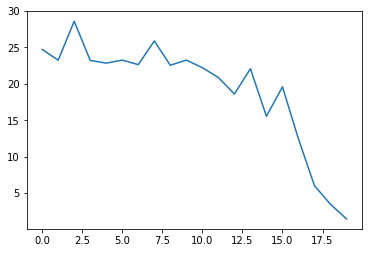

In [30]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

# Construct a mini network for MNIST
inputs = Variable()
true_label = Variable()
inputs.value = np.random.normal(size=(28, 28, 1))
inputs.dloss_dvalue = np.random.normal(size=(28, 28, 1))

op1 = OpConv2D(16, 5, inputs) # Output is 28-5+1=24
op2 = OpAvgPool(2, op1)      # Output is 24/2=12
op3 = OpRelu(op2)

op4 = OpConv2D(16, 5, op3) # Output is 12-5+1=8
op5 = OpAvgPool(2, op4)      # Output is 8/2=4
op6 = OpRelu(op5)

op7 = OpConv2D(10, 3, op6) # Output is 4-3+1=2
op8 = OpAvgPool(2, op7)      # Output is 2/2=1

op9 = OpSoftmaxCrossEntropyLoss(op8, true_label)
ops_list = [op1,op2,op3,op4,op5,op6,op7,op8,op9]

# Run for a few iterations, make sure loss is going down
learning_rate = 0.2
inputs.value = np.random.normal(size=(28, 28, 1))

mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

num_its = 20
batch_size = 10
batch_x, batch_y = mnist.train.next_batch(batch_size)

loss_list = []

for it in range(num_its):
  loss_of_batch = 0.0
  
  for im in range(batch_size):
    inputs.value = np.reshape(batch_x[im], (28,28,1))
    true_label.value = batch_y[im]
  
    for op in ops_list:
      op.forward()

    loss_of_batch += ops_list[-1].value
    
    for op in reversed(ops_list):
      op.backward()
      op.gradient_step(learning_rate)
  
  loss_list.append(loss_of_batch)
  
  print("Iteration " + str(it) + " Loss: "+str(loss_of_batch))
  
  
plt.plot(range(num_its), loss_list)
plt.show()

## 3.1.6 Extra credit (5 points)

Extend the functionality of one of these operations (e.g. add stride, dilation, or padding to the 2D Convolution) or implement a new one (e.g. fully-connected layer).



### Max Pooling layer

In [31]:
inputs = Variable()
inputs.value = np.random.normal(size=(10, 10, 3)) # Input image is 10x10x3
tf_inputs = tf.constant(inputs.value[np.newaxis, ...], dtype=tf.float32)

class OpMaxPool:
  """Max pooling layer. Non-overlapping cells."""
    
  def __init__(self, cell_size, inputs):
    # Shape of the input feature map
    self.input_height = inputs.value.shape[0] #10
    self.input_width = inputs.value.shape[1] #10
    self.input_filters = inputs.value.shape[2] #3
    
    # Shape of this layer's feature map
    self.height = (self.input_height + cell_size - 1) // cell_size #5
    self.width = (self.input_width + cell_size - 1) // cell_size #5
    self.filters = self.input_filters #3
    
    self.inputs = inputs
    self.cell_size = cell_size #2
    self.reset_values()
    
    self.max_idx = []
    
  def reset_values(self):
    self.value = np.zeros((self.height, self.width, self.filters))
    self.dloss_dvalue = np.zeros(self.value.shape)
    
  def forward(self):
    # Reset value and gradient at start of forward pass
    self.reset_values()
    
    for y in range(self.height):
      for x in range(self.width):
        for f in range(self.filters):
          max = float('-inf')
          max_idx = None
          
          for ky in range(min(self.cell_size, self.input_height - y*self.cell_size)):
            for kx in range(min(self.cell_size, self.input_width - x*self.cell_size)):  
              z = self.inputs.value[self.cell_size*y+ky, self.cell_size*x+kx, f]
              if z > max:
                max = z
                max_idx = (self.cell_size*y+ky, self.cell_size*x+kx, f) 
                
                
          self.value[y, x, f] = max
          self.max_idx.append(max_idx) 
          
          
  def backward(self):
    for y in range(self.height):
      for x in range(self.width):
        for f in range(self.filters):
          
          for ky in range(min(self.cell_size, self.input_height - y*self.cell_size)):
            for kx in range(min(self.cell_size, self.input_width - x*self.cell_size)):
              total_loss = self.dloss_dvalue[y,x,f]
              if (self.cell_size*y+ky, self.cell_size*x+kx, f) in self.max_idx:
                self.inputs.dloss_dvalue[self.cell_size*y+ky, self.cell_size*x+kx, f] = total_loss
              else:
                self.inputs.dloss_dvalue[self.cell_size*y+ky, self.cell_size*x+kx, f] = 0.0
    
                
  def gradient_step(self, step_size):
    pass
  
# Double check that each op matches tensorflow
print("\nTesting MaxPool...")
op9 = OpMaxPool(2, inputs)
tf_op9 = tf.nn.max_pool(tf_inputs, [1, 2, 2, 1], [1,2,2,1], "VALID")
cmp_ops(op9, tf_op9, tf_inputs)



Testing MaxPool...
Forward pass:
  Your Op shape: (5, 5, 3)
  TensorFlow Op shape: (5, 5, 3)
  Values equal: True
Gradient wrt inputs:
  Your Op shape: (10, 10, 3)
  TensorFlow Op shape: (1, 10, 10, 3)
  Values equal: True


# 3.2 Training an image classifier (40 points)

In [21]:
#@title (Hidden utility code: RUN ME FIRST) { display-mode: "form" }
!git clone https://github.com/tensorflow/models.git 2>/dev/null
import sys
import math
sys.path.append('/content/models/tutorials/image/cifar10/')
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['axes.facecolor'] = 'white'

import tensorflow as tf
tf.reset_default_graph()
try:
  tf.app.flags.FLAGS.f
except Exception:
  tf.app.flags.DEFINE_string('f', '', """Placeholder.""")
import cifar10
tf.app.flags.FLAGS.batch_size = 100
# from tensorflow.examples.models.tutorials.image.cifar10 import cifar10

def plot_filters(filters, xlabel=None, ylabel=None):
  print(filters.shape)
  # filters: height x width x channels x num_filters
  num_filters = filters.shape[3]
  filter_height = filters.shape[0]
  filter_width = filters.shape[1]
  filter_channels = filters.shape[2]
  spacing = 1
  rows = int(math.ceil(math.sqrt(num_filters)))
  cols = int(math.ceil(math.sqrt(num_filters)))
  plot = np.zeros((rows*(filter_height+spacing), cols*(filter_width+spacing), min(filter_channels, 3) ))
  
  min_value = np.min(filters)
  max_value = np.max(filters)
  filters = (filters - min_value) / (max_value - min_value)
  
  for f in range(num_filters):
    r = int(f/cols)
    c = f - r*cols
    plot[r*(filter_height+spacing):r*(filter_height+spacing)+filter_height,
        c*(filter_width+spacing):c*(filter_width+spacing)+filter_width,:] = filters[:,:,0:min(filter_channels, 3),f]
  
  plt.grid(False)
  plt.imshow(np.squeeze(plot))
  if xlabel is not None:
    plt.xlabel(xlabel)
  if ylabel is not None:
    plt.ylabel(ylabel)
  plt.show()

cifar10.maybe_download_and_extract()
images, labels = cifar10.inputs(False)
test_images, test_labels = cifar10.inputs(True)

^C


ModuleNotFoundError: No module named 'cifar10'

## 3.2.1 Early stopping (15 points)

We have specified a very simple convolutional neural network to classify images from the Cifar-10 dataset.  We then provide a training loop to optimize the weights of the network.  Your task is to add Early Stopping (ES) to this training loop.  Validation accuracy should be measured periodically, and training should stop if the validation accuracy does not reach a new absolute maximum after some number of measurements (this is called the "patience"). After training, we then measure the test accuracy.  Before implementing ES, run the following cell to see a plot of the training loss and validation accuracy.  Report the test accuracy you have found with ES.

## 3.2.2 Tuning hyperparameters (25 points)

The hyperparameters we have chosen are not necessarily optimal.  Pick two factors to search over (e.g. number of layers, filters per layer, learning rate, convolutional kernel size, etc.).  Then write a procedure that uses grid search to find the combination of these hyperparameters that yields the highest validation accuracy.  Finally, report the test accuracy achieved by this model.

In [ ]:
sess = tf.Session()
with sess.as_default():
  tf.train.start_queue_runners()
  im_width = 24

  # Define placeholders for image and label
  y_ = tf.placeholder(tf.float32, [None, 10])
  x = tf.placeholder(tf.float32, [None, im_width, im_width, 3])

  # Define a convolutional neural network (CNN)
  cnnL1 = tf.layers.conv2d(x, 16, 5, strides=(2,2), activation=tf.nn.relu)
  cnnL2 = tf.layers.conv2d(cnnL1, 16, 5, activation=tf.nn.relu)
  cnnL3 = tf.layers.conv2d(cnnL2, 32, 5, activation=tf.nn.relu)
  cnn = tf.reduce_sum(tf.reduce_sum(cnnL3, axis=1), axis=1)
  cnn = tf.contrib.layers.flatten(cnn)
  y_cnn = tf.layers.dense(cnn, 10)

  cross_entropy_cnn = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_cnn))
  train_step_cnn = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy_cnn)

  correct_prediction_cnn = tf.equal(tf.argmax(y_cnn, 1), tf.argmax(y_, 1))
  accuracy_cnn = tf.reduce_mean(tf.cast(correct_prediction_cnn, tf.float32))

  tf.global_variables_initializer().run(session=sess)

  # Train
  print('Training... '+str(datetime.now()))
  valid_batch_xs, valid_batch_ys = sess.run([test_images, tf.one_hot(test_labels, 10)])
  train_losses = []
  test_accuracies = []
  valid_its = []
  valid_accuracies = []
  num_its = 1000
  for it in range(num_its):
    if (it+1) % 50 == 0:
      print('Iteration %d/%d ...' % (it, num_its))

      # Validation accuracy
      valid_acc_cnn = sess.run(accuracy_cnn, feed_dict={x: valid_batch_xs, y_: valid_batch_ys})
      valid_accuracies.append(valid_acc_cnn)
      valid_its.append(it)

    batch_xs, batch_ys = sess.run([images, tf.one_hot(labels, 10)])
    loss_cnn_out, _ = sess.run([cross_entropy_cnn, train_step_cnn], feed_dict={x: batch_xs, y_: batch_ys})

    train_losses.append(loss_cnn_out)

  print('Testing... '+str(datetime.now()))
  # # Test trained model
  test_batch_xs, test_batch_ys = sess.run([test_images, tf.one_hot(test_labels, 10)])

  true_label = tf.argmax(y_, 1)
  cnn_label = tf.argmax(y_cnn, 1)
  acc_cnn_out, true_label_out, cnn_label_out = sess.run([accuracy_cnn, true_label, cnn_label], feed_dict={x: test_batch_xs,
                                      y_: test_batch_ys})
  
# Plot train loss and validation accuracy
plt.plot(range(it+1), train_losses)
plt.ylabel('Training loss')
plt.xlabel('Iteration')
plt.show()
plt.plot(valid_its, valid_accuracies)
plt.ylabel('Validation accuracy')
plt.xlabel('Iteration')
plt.show()

print('Test accuracy: ' + str(acc_cnn_out*100)+ '%%')


If you are curious what the weights, activations, or confused images look like, we visualize them below.  Feel free to modify this code to inspect other aspects of your trained model.

In [ ]:
with sess.as_default():
  # Show weights from the first layer
  print('Weights from the first layer')
  with tf.variable_scope("conv2d_1", reuse=True):
    weights = tf.get_variable('kernel')
  plot_filters(weights.eval())

  # Show activations from the first feature map
  print('Activations from the first feature map.')
  fmap = cnnL1.eval(feed_dict={x: test_batch_xs, y_: test_batch_ys})
  plot_filters(np.transpose(fmap[0:1,...], (1,2,0,3)))

  # Show images in a confusion matrix
  confusion = np.zeros((24,24,3,100))
  for b in range(true_label_out.shape[0]):
    confusion[:,:,:,true_label_out[b]*10 + cnn_label_out[b]] = test_batch_xs[b]

  plot_filters(confusion, ylabel='True label', xlabel='Guessed label')

